# 

# Predict stock forecast

An attempt to predict stock forecast with data from https://finance.yahoo.com/.

In [32]:
import datetime

import yfinance as yf

Defining constants

In [33]:
DAYS = 1461  # 4 years
SYMBOL = "TSLA"

start = datetime.date.today() - datetime.timedelta(days=DAYS)
end = datetime.datetime.today()

Library yfinance parses data from Yahoo finance, in this case TSLA data 4 years prior. Tesla has a lot of spikes so may change later to Apple (AAPL) or similar.

In [34]:
data = yf.download(SYMBOL, start, end)
data.to_csv(r'data\tsla_data.csv')

[*********************100%***********************]  1 of 1 completed


In [35]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Plot on closing 60 days prior.

<Axes: xlabel='Date'>

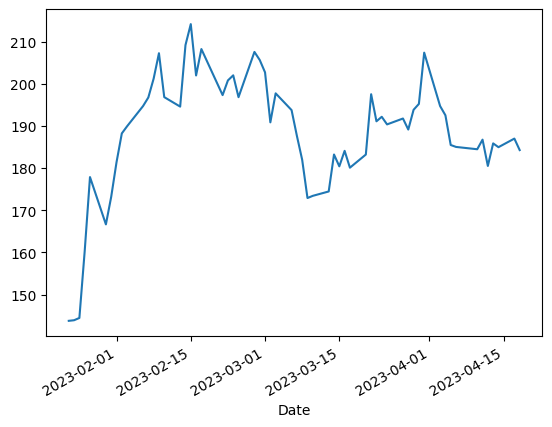

In [36]:
tmp = data.iloc[-60:]  # 60 days
tmp['Close'].plot()

Smooths dataset 

<Axes: xlabel='Date'>

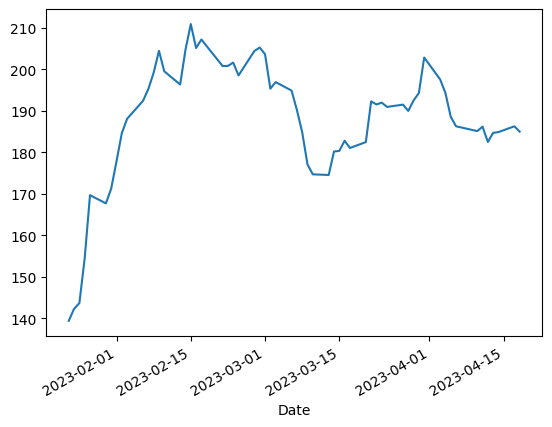

In [37]:
# alpha as weight factor, weight recent values more
data = data.ewm(alpha=0.65).mean()
temp = data.iloc[-60:]  # 60 days
temp['Close'].plot()

The historical data is not very rich of features. Open, High, Low, Adj Close are not very interesting as Close can fulfil the need. FinTA library can do financial analysis with list of symbols as indicators:

In [38]:
from finta import TA

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


In [39]:
# Lower columns needed for finta processing
data.columns = data.columns.str.lower()

for indicator in INDICATORS:
    indicator_data = eval(f'TA.{indicator}(data)')

    # Add indicator to dataframe
    data = data.merge(indicator_data, left_index=True, right_index=True)
data.columns = data.columns.str.replace('.', '')

# Calculate moving averages for features
data['ema50'] = data['close'].ewm(50).mean()
data['ema20'] = data['close'].ewm(20).mean()
data['ema15'] = data['close'].ewm(15).mean()
data['ema5'] = data['close'].ewm(5).mean()

# We can use normalized volume instead of actual
data['norm_volume'] = data['volume'] / data['volume'].ewm(5).mean()
# Drop unnecessary columns
data.drop(columns=['open', 'high', 'low', 'adj close', 'volume'], axis=1, inplace=True)

data.columns


Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema20', 'ema15', 'ema5',
       'norm_volume'],
      dtype='object')

In [40]:
data.to_csv(r'data\tsla_data_emw.csv')

In [41]:
data.head(10)

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema20,ema15,ema5,norm_volume
Date,,,,,,,,,,,,,,,,,,,,
2019-04-22,17.516666,NaN,0.000000,0.000000,NaN,-1.685413e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.516666,17.516666,17.516666,17.516666,1.000000
2019-04-23,17.573456,100.000000,0.001274,0.000708,NaN,-1.123216e+08,NaN,NaN,NaN,NaN,1.688376e+08,-66.666667,NaN,NaN,NaN,17.545342,17.545754,17.545977,17.547643,0.965259
2019-04-24,17.349716,19.073546,-0.005315,-0.001760,NaN,-1.762809e+08,NaN,NaN,NaN,NaN,5.382079e+06,-82.262283,NaN,NaN,NaN,17.478838,17.477195,17.476292,17.469342,0.959352
2019-04-25,16.794706,6.032322,-0.028220,-0.010724,NaN,-3.586006e+08,NaN,NaN,NaN,NaN,-2.664859e+08,-133.333333,NaN,NaN,NaN,17.302692,17.293890,17.289063,17.252171,1.338917
2019-04-26,16.063707,3.062388,-0.069160,-0.028107,NaN,-5.265265e+08,NaN,NaN,NaN,NaN,-5.798746e+08,-137.731531,NaN,NaN,NaN,17.044985,17.023280,17.011384,16.921006,1.340435
2019-04-29,16.086038,4.607473,-0.091516,-0.045294,NaN,-4.876566e+08,NaN,NaN,NaN,NaN,-3.072972e+08,-110.479317,NaN,NaN,NaN,16.877145,16.847420,16.831253,16.711773,1.119348
2019-04-30,15.973275,4.239963,-0.109385,-0.061514,NaN,-5.261137e+08,NaN,NaN,NaN,NaN,-4.949244e+08,-86.489713,NaN,NaN,NaN,16.740225,16.703544,16.683732,16.541042,0.813669
2019-05-01,15.731025,3.579425,-0.131129,-0.078244,NaN,-5.830285e+08,NaN,NaN,NaN,NaN,-6.649579e+08,-88.740903,NaN,NaN,NaN,16.605160,16.560239,16.536083,16.365127,0.781972
2019-05-02,16.083553,22.500623,-0.126701,-0.089438,NaN,-5.531401e+08,NaN,NaN,NaN,NaN,-4.283878e+08,-57.144732,NaN,NaN,NaN,16.542508,16.496368,16.471887,16.306916,1.068537


In [42]:
# TODO 1.Remove sample data for later predictions with training set and test set.
# TODO 2. Create 0 and 1 values by comparing one day from another with df.shift().
# TODO 3. Drop NaN values with dropna().
# TODO 4. Model creation. Possibly will try KNN, Random forest model, SVM.
